# 유사 상품군 클러스터링

## Clustering 기본 이론
---
**Clustering의 방식(https://www.nextobe.com/single-post/2018/02/26/데이터-과학자가-알아야-할-5가지-클러스터링-알고리즘)**
1. K-Means Clustering
    
2. Mean-Shift Clustering
3. Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
4. Gaussian Mixture Models (GMM)을 사용한 Expectation-Maximization (EM) 클러스터링
5. Agglomerative Hierarchical Clustering  

**Clustering의 시간복잡도**(https://www.secmem.org/blog/2019/05/17/clustering/)
1. 거리 기반 계층적 클러스터링  
    유클리드 공간 : 평균 등의 방법으로 centroid 결정 - cluster centroid간 거리 계산 - 가까운 cluster끼리 합침 - 반복  
    비유클리드 공간(문자열간 cluster) : 클러스터 내부의 거리를 최소화하는 임의의 clustorid 선정 - clusteroid간 거리 계산  
    
    O(N^3)

2. Point Assignment Clustering
    K-means : 임의의 K개 centroid를 사전에 결정 - 이를 바탕으로 주변의 가장 가까운 점들을 cluster - 새로운 K개 centroid에 대해 반복  
    
    O(NktlogN)
    
    유클리디안 거리를 통해 가까운 점들을 cluster하므로, 원형 형태가 아닌 경우 성능 저하



## 이미지 클러스터링 이론
---
**이미지추천에서 단순 유사도계산방식 대비 Clustering 장점**  
    
    매번 모든 데이터에 대해 재계산을 할 필요가 없다
    새롭게 들어온 데이터가 어느 cluster에 속하는지만 판단하면 된다

**유클리디안 거리 사용시 차원의 저주 (https://yamalab.tistory.com/39)**
1. (비 이미지 데이터의 경우) latent variable들을 그대로 살려두면, 근본 feature variable 개수 대비 데이터의 밀도가 떨어진다.  
따라서 차원을 축소시켜 latent variable을 제거하면 성능이 개선된다


**그렇다고 이미지에서 PCA등의 차원축소를 해도 되나?**
1. (이미지 데이터의 경우) 그러나 이미지 데이터에는 PCA등의 기법으로 함부로 차원을 축소시키기 어렵다.  
모든 픽셀 하나하나가 나름대로의 의미를 갖기 때문이다

**이미지 데이터 clustering (https://yamalab.tistory.com/118)**
방법
1. Euclidean 거리 기반
2. Spherical 거리 기반  
3. PCA로 차원축소
4. **t-SNE로 차원축소**
-----------------
5. **AutoEncoder**

**클러스터링을 통한 추천**
1. train dataset을 통한 클러스터링 모델 학습
2. 임의의 이미지 입력받음
3. 해당 이미지에 대해 클러스 분류
4. 해당 클러스터에 속하는 물품들 확인

## 이미지 클러스터링 적용 예제

데이터 준비

---
클러스터링에 들어가는 데이터는
1. 이미지 raw array
2. feature extract되어 차원축소된 이미지

뭘 써야되나?

In [1]:
import os
os.chdir('..')

In [2]:
%time
import pickle
import numpy as np
from numpy import (array, unravel_index, nditer, linalg, random, subtract,
                   power, exp, pi, zeros, arange, outer, meshgrid, dot,
                   logical_and, mean, std, cov, argsort, linspace, transpose)
import pandas as pd
import math
import tensorflow as tf

Wall time: 0 ns


In [3]:
%time
#이미지 id_feature_map 불러오기
#pickle 데이터 사용
#3000x1000 array 불러오는데 시간 : 0ms? 빠른데?
with open('prep_data/train_feature.pickle', 'rb') as f:
    id_feature_map = pickle.load(f)
    
#현재 errror뜨는 이미지들은 제거된 상태
id_feature_map = pd.Series(id_feature_map)

Wall time: 0 ns


이미지 데이터 준비

In [7]:
import pymysql
import json

def connect_db(dbinfo_path) :
    with open(dbinfo_path) as jsonfile :
        dbinfo = json.load(jsonfile)

    connection = pymysql.connect(host=dbinfo['host'],
                         port=dbinfo['port'],
                         user=dbinfo['user'], 
                         passwd=dbinfo['passwd'],
                         db=dbinfo['db'],
                         charset=dbinfo['charset'])
    
    return connection

In [8]:
db = connect_db('dbinfo-temp.json')
cur = db.cursor()

In [9]:
#옷 마이너 받아오기
sql = """SELECT clothes_id,minor FROM CLOTHES_AND_CLOTHES_CLASS 
INNER JOIN CLOTHES ON CLOTHES.id = CLOTHES_AND_CLOTHES_CLASS.clothes_id 
INNER JOIN CLOTHES_CLASS ON CLOTHES_AND_CLOTHES_CLASS.clothes_class_id = CLOTHES_CLASS.id
WHERE clothes_class_id IN 
(SELECT id FROM CLOTHES_CLASS 
WHERE (major="남" OR major="여") 
AND (middle != "" AND middle != "가방" AND middle!="스포츠/용품")) 
ORDER  BY clothes_id ASC 
LIMIT 3000;"""

cur.execute(sql)

3000

In [10]:
#id_minor_map 만들기
id_minor_map = {}
for id,minor in cur :
    id_minor_map[id] = minor
id_minor_map = pd.Series(id_minor_map)

In [11]:
#id_feature와 id_minor의 id 일치화
for key in id_minor_map.index :
    if key not in id_feature_map.index :
        id_minor_map.drop(key,inplace=True)

In [12]:
%time
# 옷 feature array/minor array 만들기
feature_array = []
for feat in id_feature_map :
    feature_array.append(np.squeeze(feat,0))
feature_array = np.array(feature_array)

minor_array = []
for minor in id_minor_map :
    minor_array.append(minor)
minor_array = np.array(minor_array)

Wall time: 0 ns


#### 1. Euclidean 거리 기반(K-means)

In [100]:
#from scikit learn의 k means 사용
from sklearn.cluster import KMeans        

In [102]:
%time

kmeans = KMeans(n_clusters=34, random_state=0).fit(feature_array)

Wall time: 0 ns


In [113]:
kmeans.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 34,
 'n_init': 10,
 'n_jobs': None,
 'precompute_distances': 'auto',
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 0}

In [103]:
kmeans.labels_

array([31, 30, 30, ..., 15, 16, 20])

In [107]:
#라벨링 된 결과물 평가
#그냥 눈으로만 봐도 엉망임
for label,pred in zip(minor_array,kmeans.labels_) :
    print(label,pred)

반팔 티셔츠 31
반팔 티셔츠 30
반팔 티셔츠 30
반팔 티셔츠 9
반팔 티셔츠 16
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 30
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 30
반팔 티셔츠 30
반팔 티셔츠 5
반팔 티셔츠 25
반팔 티셔츠 25
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 30
반팔 티셔츠 30
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 33
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 19
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 15
반팔 티셔츠 5
반팔 티셔츠 31
반팔 티셔츠 30
반팔 티셔츠 30
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 30
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 22
반팔 티셔츠 30
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 30
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 33
반팔 티셔츠 15
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
반팔 티셔츠 5
긴팔 티셔츠 25
긴팔 티셔츠 17
긴팔 티셔츠 33
긴팔 티셔츠 2
긴팔 티셔츠 7
긴팔 티셔츠 16
긴팔 티셔츠 15
긴팔 티셔츠 16
긴팔 티셔츠 30
긴팔 티셔츠 30
긴팔 티셔츠 12
긴팔 티셔츠 4
긴팔 티셔츠 16
긴팔 티셔츠 9
긴팔 티셔츠 1
긴팔 티셔츠 9
긴팔 티셔츠 25
긴팔 티셔츠 10
긴팔

겨울 기타 코트 0
겨울 기타 코트 18
겨울 기타 코트 0
겨울 기타 코트 0
겨울 기타 코트 23
롱 패딩/롱 헤비 아우터 6
롱 패딩/롱 헤비 아우터 23
롱 패딩/롱 헤비 아우터 23
롱 패딩/롱 헤비 아우터 23
롱 패딩/롱 헤비 아우터 15
롱 패딩/롱 헤비 아우터 23
롱 패딩/롱 헤비 아우터 16
롱 패딩/롱 헤비 아우터 18
롱 패딩/롱 헤비 아우터 6
롱 패딩/롱 헤비 아우터 20
롱 패딩/롱 헤비 아우터 9
롱 패딩/롱 헤비 아우터 18
롱 패딩/롱 헤비 아우터 18
롱 패딩/롱 헤비 아우터 15
롱 패딩/롱 헤비 아우터 6
롱 패딩/롱 헤비 아우터 32
롱 패딩/롱 헤비 아우터 15
롱 패딩/롱 헤비 아우터 33
롱 패딩/롱 헤비 아우터 6
롱 패딩/롱 헤비 아우터 27
롱 패딩/롱 헤비 아우터 6
롱 패딩/롱 헤비 아우터 18
롱 패딩/롱 헤비 아우터 9
롱 패딩/롱 헤비 아우터 15
롱 패딩/롱 헤비 아우터 12
롱 패딩/롱 헤비 아우터 9
롱 패딩/롱 헤비 아우터 15
롱 패딩/롱 헤비 아우터 15
롱 패딩/롱 헤비 아우터 6
롱 패딩/롱 헤비 아우터 6
롱 패딩/롱 헤비 아우터 18
롱 패딩/롱 헤비 아우터 9
롱 패딩/롱 헤비 아우터 18
롱 패딩/롱 헤비 아우터 24
롱 패딩/롱 헤비 아우터 1
롱 패딩/롱 헤비 아우터 15
롱 패딩/롱 헤비 아우터 9
롱 패딩/롱 헤비 아우터 18
롱 패딩/롱 헤비 아우터 23
롱 패딩/롱 헤비 아우터 6
롱 패딩/롱 헤비 아우터 15
롱 패딩/롱 헤비 아우터 18
롱 패딩/롱 헤비 아우터 12
롱 패딩/롱 헤비 아우터 23
롱 패딩/롱 헤비 아우터 18
롱 패딩/롱 헤비 아우터 15
롱 패딩/롱 헤비 아우터 13
롱 패딩/롱 헤비 아우터 23
롱 패딩/롱 헤비 아우터 15
롱 패딩/롱 헤비 아우터 18
롱 패딩/롱 헤비 아우터 23
롱 패딩/롱 헤비 아우터 23
롱 패딩/롱 헤비 아우터 18
롱 패딩/롱 헤비 아우터 27
롱 패딩/롱 헤비 아우터 15
롱 패딩/롱 헤비 아우터 0
롱 패딩/롱

#### 2. DBSCAN

In [109]:
#scikit learn의 클러스터링 패키지 사용
from sklearn.cluster import DBSCAN

In [127]:
#input으로 2D-array 입력
#options는  https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
dbscan = DBSCAN().fit(feature_array)

In [128]:
dbscan.get_params()

{'algorithm': 'auto',
 'eps': 0.5,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 5,
 'n_jobs': None,
 'p': None}

In [130]:
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [131]:
#각 datapoint들의 cluster number
#-1은 noisy sample을 의미
for label in clustering.labels_ :
    print(label)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


#### KNN 적용

---

개념

    거리 + 등장비율
    가장 가까운 것들을 추가하되, 등장비율이 높은 놈만 동류로 취급해 산입한다
    
hyperparameter

    Nearest Neighor K : 등장비율을 계산할 떄 사용되는 K값

최적의 K값 선정

    rule of thumb : 총 데이터 개수의 sqrt값
    (예시 : 데이터 10000개 -> k 는 100개)

#### t-SNE 적용

---

이를 통해 이미지를 2차원상에 plot할 수 있다고 함  
단, 시간복잡도가 O(N^2)인 알고리즘임에 주의
이를 위해 차원을 50차원 정도로 줄인 후 tSNE적용 필요

https://skyeong.net/186 참조. MNIST 784 -> 3으로 PCA 차원축소 후 TSNE



In [4]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

In [13]:
#fit고 ㅏfit transform의 차이는? -> 결과가 object로 나오느냐, array로 나오느냐
# options로 들어가는 것은?
tsne_result = tsne.fit(feature_array)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2988 samples in 0.386s...
[t-SNE] Computed neighbors for 2988 samples in 8.260s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2988
[t-SNE] Computed conditional probabilities for sample 2000 / 2988
[t-SNE] Computed conditional probabilities for sample 2988 / 2988
[t-SNE] Mean sigma: 0.042961
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.557541
[t-SNE] KL divergence after 300 iterations: 1.192586


In [16]:
tsne_result_tf = tsne.fit_transform(feature_array)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2988 samples in 0.384s...
[t-SNE] Computed neighbors for 2988 samples in 8.199s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2988
[t-SNE] Computed conditional probabilities for sample 2000 / 2988
[t-SNE] Computed conditional probabilities for sample 2988 / 2988
[t-SNE] Mean sigma: 0.042961
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.850410
[t-SNE] KL divergence after 300 iterations: 1.197826


In [ ]:
tsne_result_tf

In [ ]:
# ggplot 이용 시각화
# ggplot\utils.py 에서 module 'pandas' has no attribute 'tslib'에러 주의
# ggplot/stats/smoothers.py 에서 No module named 'pandas.lib' 에러 주의
#해결법 : 해당 소스코드 직접 변경 https://github.com/yhat/ggpy/issues/662
from ggplot import *

df_tsne = pd.DataFrame()
df_tsne['x-tsne'] = tsne_result_tf[:,0]
df_tsne['y-tsne'] = tsne_result_tf[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne') ) \
    + geom_point(size=70,alpha=0.1) \
    + ggtitle("tSNE dimensions colored by digit")
chart

#### 5. Autoencoder 적용

**SOM 적용**

---
원리 http://jaynewho.com/post/7

과정

    지도학습 기반 분류모델 훈련  
    -> 분류모델 이용 feature extraction  
    -> SOM이용 클러스터링



#### SOM 라이브러리 적용 - 색상 SOM

In [ ]:
#SOM 가능 라이브러리에는 SOMBER,SOMPY등이 있음
import numpy as np
from sklearn import metrics
from somber import Som

In [ ]:
# 3개의 feature를 가진 color들을 cluster해보자
X = color = np.array([[0., 0., 0.],
              [0., 0., 1.],
              [0., 0., 0.5],
              [0.125, 0.529, 1.0],
              [0.33, 0.4, 0.67],
              [0.6, 0.5, 1.0],
              [0., 1., 0.],
              [1., 0., 0.],
              [0., 1., 1.],
              [1., 0., 1.],
              [1., 1., 0.],
              [1., 1., 1.],
              [.33, .33, .33],
              [.5, .5, .5],
              [.66, .66, .66]])

color_names = ['black', 'blue', 'darkblue', 'skyblue',
               'greyblue', 'lilac', 'green', 'red',
               'cyan', 'violet', 'yellow', 'white',
               'darkgrey', 'mediumgrey', 'lightgrey']

In [ ]:
# initialize
# (map x,map y),data_dim,learning_rate
s = Som((15, 15),3,learning_rate=0.3)

# train
# 10 updates with 10 epochs = 100 updates to the parameters.
s.fit(color, num_epochs=10, updates_epoch=10)

In [ ]:
# predict: get the index of each best matching unit.
# output : 입력 data 하나하나에 대해
# 예측(clustering)된 map unit(node)
predictions = s.predict(X)
predictions

In [ ]:
# quantization error: how well do the best matching units fit?
# 입력값과 예측된 map unit(node) parameter과의 오차?
quantization_error = s.quantization_error(X)
quantization_error

In [ ]:
# inversion: associate each node with the exemplar that fits best.
# 각 맵의 unit(node) 의 카테고리
#근데 2차원이 아니라 1차원이라 좀 애매함
inverted = s.invert_projection(X, color_names)
inverted

In [ ]:
# Mapping: get weights, mapped to the grid points of the SOM
# 맵을 map_x,map_y,data_dim을 갖는 2차원 맵으로 시각화
mapped = s.map_weights()

import matplotlib.pyplot as plt
plt.imshow(mapped)

#### SOM 라이브러리 적용 - 이미지 SOM

---
인풋 : 3000개 이미지 feature  
아웃풋 : 그래도 카테고리가 40개니까 최소 10x10은 잡아야함  
15x15x1000


SOM 모델 생성 및 훈련

In [ ]:
%time

# initialize
# (map x,map y),data_dim
# 옵션으로 들어갈 수 있는 것들 : 
s = Som((15, 15),1000,learning_rate=0.5, lr_lambda=2.5, infl_lambda=2.5)

# train
# 10 updates with 10 epochs = 100 updates to the parameters.
# 2988*1000 훈련시키는데 꽤 많은 시간 부하
s.fit(feature_array, num_epochs=10, updates_epoch=10,show_progressbar=True)

모델 평가

In [ ]:
# predict: get the index of each best matching unit.
# output : 입력 data 하나하나에 대해 예측(clustering)된 map unit(node)
predictions = s.predict(feature_array)
predictions

In [ ]:
#예측한 클러스터의 개수
np.unique(predictions).shape

In [ ]:
# quantization error: how well do the best matching units fit?
# 입력값과 예측된 map unit(node) parameter과의 오차?
quantization_error = s.quantization_error(feature_array)
quantization_error

In [ ]:
# inversion: associate each node with the exemplar that fits best.
# 각 맵의 unit(node) 의 카테고리 확인
# 정확히 어떻게 보는건지 아직 잘 모르겠음
inverted = s.invert_projection(feature_array,minor_array)
#inverted = s.invert_projection(feature_array,predictions)
inverted

In [ ]:
#실제 카테고리와 예측된 카테고리 차이 확인

#predictions에서 번호 따서 inverted에 넣어보기
predicted_minor = []
for i in range(len(predictions)) :
    predicted_minor.append(inverted[predictions[i]])

In [ ]:
predicted_minor

In [ ]:
# Mapping: get weights, mapped to the grid points of the SOM
# 맵을 map_x,map_y,data_dim을 갖는 2차원 맵으로 시각화
# 단, feature가 1000이므로 시각화 불가능
mapped = s.map_weights()
mapped.shape

In [90]:
def fast_norm(x):

    return math.sqrt(dot(x, x.T))

In [91]:
"""Returns the distance map of the weights.
Each cell is the normalised sum of the distances between
a neuron and its neighbours."""
def distance_map(self):
    um = zeros((self.shape[0], self.shape[1]))
    it = nditer(um, flags=['multi_index'])
    while not it.finished:
        for ii in range(it.multi_index[0] - 1, it.multi_index[0] + 2):
            for jj in range(it.multi_index[1] - 1, it.multi_index[1] + 2):
                if (ii >= 0 and ii < self.shape[0] and
                        jj >= 0 and jj < self.shape[1]):
                    w_1 = self[ii, jj, :]
                    w_2 = self[it.multi_index]
                    um[it.multi_index] += fast_norm(w_1 - w_2)
        it.iternext()
    um = um / um.max()
    return um

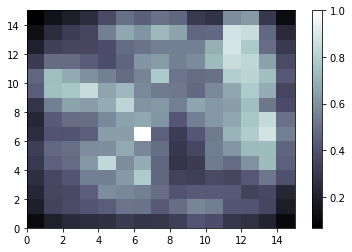

In [92]:
from pylab import bone, pcolor, colorbar, plot, show
bone()
distance = distance_map(mapped).T
pcolor(distance)
colorbar()
show()

성능 수치화

In [93]:
def evaluation(labels_true,labels_pred):
    """
    정답 레이블과 예측 레이블 파일을 읽어서 Adjusted Rand index를 계산하여 반환하는 함수입니다.
    :param labels_true_path: 정답 이미지 레이블 파일
    labels_true의 예:
    01
    01
    01
    02
    02
    03
    ...
    :param labels_pred_path: 예측 이미지 레이블 파일
    labels_pred의 예:
    01
    01
    02
    02
    03
    04
    ...
    :return: Adjust Rand index (0~1) 계산하여 출력하고 점수를 반환함. 1에 가까울수록 정확
    예:
    Rand Index: 0.18918918918918917
    참고: https://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-index
    """

    # loading labels

    print('True number of clusters: %d' % len(np.unique(labels_true)))
    print('Predicted number of clusters: %d' % len(np.unique(labels_pred)))

    # compare labels
    return metrics.adjusted_rand_score(labels_true, labels_pred)

In [97]:
# 1에 가까울수록 우수한 결과
evaluation(minor_array,predictions)

True number of clusters: 34
Predicted number of clusters: 220


0.06517503788368642

네이버코드

네이버 campusfest 이미지 클러스터링 분야 장려상
https://github.com/sunnys-lab/2019-6thD2CF-Image-Cluster

## FAISS 벡터유사도 라이브러리
---
https://tensorflow.blog/tag/faiss/

개요

    GPU 이용, trainable한 유사도 측정 라이브러리

대상 feature size
    
    Faiss handles collections of vectors of a fixed dimensionality d, typically a few 10s to 100s.
    
설치법

    1. conda를 써서 하거나(conda 없으면 어떡하라고..)
    2. 직접 빌드하거나

튜토리얼

    https://github.com/facebookresearch/faiss/wiki/Getting-started

설치

In [21]:
# 설치가 너무 귀찮아서 FAISS는 나중으로 미루는 걸로
# 유사도검색 부분의 속도가 너무 느려지지 않으면 안 써도 됨

numpy array로 데이터 준비

In [11]:
import numpy as np
d = 64                           # dimension
nb = 100000                      # database size
nq = 10000                       # nb of queries
np.random.seed(1234)             # make reproducible

In [12]:
xb = np.random.random((nb, d)).astype('float32')

In [13]:
xb

array([[0.19151945, 0.62210876, 0.43772775, ..., 0.62491673, 0.4780938 ,
        0.19567518],
       [0.38231745, 0.05387368, 0.4516484 , ..., 0.15139526, 0.33517465,
        0.65755177],
       [0.07334255, 0.0550064 , 0.3231948 , ..., 0.34441698, 0.6408804 ,
        0.12620533],
       ...,
       [0.81447345, 0.5902453 , 0.7988935 , ..., 0.339859  , 0.3019495 ,
        0.85385454],
       [0.6714615 , 0.9160688 , 0.9550788 , ..., 0.59536433, 0.03849181,
        0.10563799],
       [0.85663575, 0.59113413, 0.67890793, ..., 0.21897699, 0.06530159,
        0.21753833]], dtype=float32)

In [14]:
xb.shape

(100000, 64)

In [15]:
xb[:, 0] += np.arange(nb) / 1000.

In [16]:
np.arange(nb)

array([    0,     1,     2, ..., 99997, 99998, 99999])

In [17]:
xb

array([[1.91519454e-01, 6.22108757e-01, 4.37727749e-01, ...,
        6.24916732e-01, 4.78093803e-01, 1.95675179e-01],
       [3.83317441e-01, 5.38736843e-02, 4.51648414e-01, ...,
        1.51395261e-01, 3.35174650e-01, 6.57551765e-01],
       [7.53425434e-02, 5.50063960e-02, 3.23194802e-01, ...,
        3.44416976e-01, 6.40880406e-01, 1.26205325e-01],
       ...,
       [1.00811470e+02, 5.90245306e-01, 7.98893511e-01, ...,
        3.39859009e-01, 3.01949501e-01, 8.53854537e-01],
       [1.00669464e+02, 9.16068792e-01, 9.55078781e-01, ...,
        5.95364332e-01, 3.84918079e-02, 1.05637990e-01],
       [1.00855637e+02, 5.91134131e-01, 6.78907931e-01, ...,
        2.18976989e-01, 6.53015897e-02, 2.17538327e-01]], dtype=float32)

In [18]:
xq = np.random.random((nq, d)).astype('float32')
xq[:, 0] += np.arange(nq) / 1000.

In [ ]:
xq.shape

Index객체 생성

In [20]:
import faiss

ModuleNotFoundError: No module named 'faiss'